In [34]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [35]:
import torchvision 
import torchvision.transforms as transforms
transform= transforms.Compose([transforms.ToTensor(),\
                            transforms.Normalize((0.1307,),(0.3081,))])
#Global Mean and Std of MNIST Database

In [36]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
trainset= torchvision.datasets.MNIST(root='./data',train=True, download=True,\
                                     transform=transform)
trainset, valset= random_split(trainset, [50000,10000])

trainloader= DataLoader(trainset, batch_size=128, drop_last=False,\
                                    num_workers=2, shuffle=True)
valloader= DataLoader(valset, batch_size=128, drop_last=False,\
                                  num_workers=2, shuffle=True)

testset= torchvision.datasets.MNIST(root='./data', train=False, download=True, \
                                    transform=transform)
testloader= DataLoader(testset, batch_size=128, drop_last=False,\
                                   shuffle=True, num_workers=2)

print(len(trainset), len(valset), len(testset))

50000 10000 10000


In [37]:
trainset[0][0].shape

torch.Size([1, 28, 28])

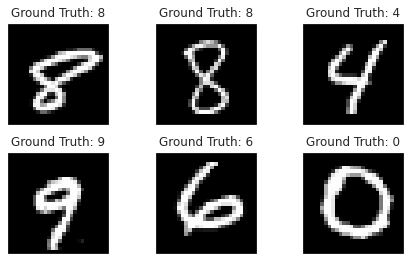

In [61]:
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [75]:
import torch.nn.functional as F
import torch.nn as nn
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_layer_size=128):
        torch.manual_seed(0)
        super(NeuralNetwork, self).__init__()
        self.linear1= nn.Linear(28*28,hidden_layer_size)
        self.linear2= nn.Linear(hidden_layer_size,10)

    def forward(self, X):
        #We have to do this because input dimension is 1x28x28
        #We have to flatten it into a continuous array not matrix!
        #X is 128 (batch_size)x1x28x28 we need to convert it to 128x784
        #So we begin flattening from dimension at index 1, and go upto lastindex
        X1=torch.flatten(X, start_dim=1, end_dim=-1)
        a1= self.linear1(X1)
        h1= torch.relu(a1)
        a2= self.linear2(h1)
        return a2

In [76]:
#torch.cuda.device_count()
torch.cuda.device(0)
cuda0= torch.device('cuda:0')

In [77]:
nn1= NeuralNetwork()
nn1.to(cuda0)

NeuralNetwork(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)

In [78]:
from torch import optim
loss_function= nn.CrossEntropyLoss()
class Model():    
    def __init__(self, nnModel, epochs, lr):
        self.nnModel= nnModel
        self.epochs= epochs
        self.lr= lr
        self.train_loss_arr=[]
        self.val_loss_arr= []
        self.test_loss= 0
        self.train_accuracy=[]
        self.val_accuracy=[]
        self.test_accuracy=0 
    
    def fit(self):
        nnModel= self.nnModel
        optimiser= optim.SGD(self.nnModel.parameters(), lr= self.lr)
        for epoch in range(self.epochs):
            #This is written because we're fitting it w.r.t nn1 architecture 
            #And so that gradient calculations can be done properly
            
            #Training Begins
            nnModel.train()
            total_train_loss=0
            correct_predict=0
            for batch in trainloader:
                X= batch[0].to(cuda0)
                y= batch[1].to(cuda0)
                optimiser.zero_grad()
                y_pred= nnModel(X)

                #To get accuracy of train set
                prediction= torch.argmax(y_pred, dim=1) 
                correct_predict+= (prediction==y).sum().item()
                
                #For Train Loss
                loss= loss_function(y_pred,y)
                total_train_loss+= loss.item() #Since it is a tensor
                loss.backward() #Because we're doing batch G.D so not total_loss
                optimiser.step()
            
            acc= 100*correct_predict/50000
            self.train_accuracy.append(acc)
            total_train_loss/= 50000
            self.train_loss_arr.append(total_train_loss)
                
            #Cross Validation Begins
            total_val_loss=0
            nnModel.eval() #Ensures that no gradients are being calculated
            correct_predict=0
            for batch in valloader:
                X= batch[0].to(cuda0)
                y= batch[1].to(cuda0)
                y_val_pred= nnModel(X)

                #To get accuracy of Validation set
                prediction= torch.argmax(y_val_pred, dim=1) 
                correct_predict+= (prediction==y).sum().item()

                #For Validation Loss
                loss= loss_function(y_val_pred, y)
                total_val_loss+= loss.item()
            
            acc= 100*correct_predict/10000
            self.val_accuracy.append(acc)
            total_val_loss/= 10000
            self.val_loss_arr.append(total_val_loss)
            
            print(f"Epoch-->{epoch} Training Error = {total_train_loss} CrossVal Error = {total_val_loss}")

    def test(self):
        #total_test_loss=0
        correct_predict=0
        with torch.no_grad():
            for batch in testloader:
                X= batch[0].to(cuda0)
                y= batch[1].to(cuda0)
                output_prob= self.nnModel(X)
                
                #Finds position of maxium probability, which is actually 
                #The predicted class
                prediction= torch.argmax(output_prob, dim=1) 
                correct_predict+= (prediction==y).sum().item()

                #To get Test Loss
                loss= loss_function(output_prob, y)
                self.test_loss+= loss.item()
        
        self.test_loss/= 10000
        self.test_accuracy=100*correct_predict/10000
        print("Test Set Accuracy is : %.3f"%self.test_accuracy)

**I've actually divided all the losses, train, test, validation, by the number of samples each of the losses had to give in essence an average loss over the entire dataset's train/ test/ validation** 

Please Consider it! It isn't a mistake, It just seemed more appropriate to compare Validation and Train Loss by their average and not just

In [79]:
#Yes I know I've later divided the loss functions by the number of samples 
#For each Train/Val/ Test sets, it isn't a mistake! Please consider it!
#I know it was asked to report oss, but I found it more appropriate to compare
#The average losses (Loss divided by number of samples) rather than the entire
#Magnitude because of different sample sizes!
model1= Model(nn1, 20, lr=1e-3)
model1.fit()

Epoch-->0 Training Error = 0.015389625196456909 CrossVal Error = 0.013020533347129822
Epoch-->1 Training Error = 0.010800476109981538 CrossVal Error = 0.009095426988601685
Epoch-->2 Training Error = 0.007819639712572098 CrossVal Error = 0.006888541430234909
Epoch-->3 Training Error = 0.00618835452914238 CrossVal Error = 0.005678252011537552
Epoch-->4 Training Error = 0.005248547937870026 CrossVal Error = 0.0049489435464143755
Epoch-->5 Training Error = 0.00465303244292736 CrossVal Error = 0.004457595971226692
Epoch-->6 Training Error = 0.004246447193026543 CrossVal Error = 0.004093893474340439
Epoch-->7 Training Error = 0.003948515655994416 CrossVal Error = 0.0038873601883649828
Epoch-->8 Training Error = 0.0037230246448516848 CrossVal Error = 0.0036594004362821577
Epoch-->9 Training Error = 0.003547214044332504 CrossVal Error = 0.00348463000357151
Epoch-->10 Training Error = 0.0034021473926305773 CrossVal Error = 0.0033563046187162398
Epoch-->11 Training Error = 0.0032818146169185636 

In [80]:
model1.test()

Test Set Accuracy is : 90.540


#**Q8)a) Plot of Test and Val Loss vs Epochs**

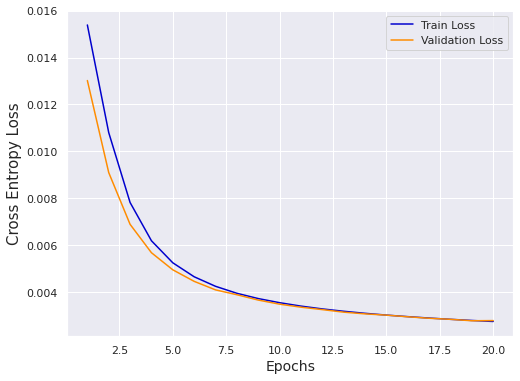

In [81]:
plt.subplots(figsize=(8,6))
e=np.arange(1,21)
plt.plot(e,model1.train_loss_arr, color='mediumblue',label='Train Loss')
plt.plot(e,model1.val_loss_arr, color='darkorange',label='Validation Loss')
plt.legend()
plt.xlabel('Epochs', size=14)
plt.ylabel('Cross Entropy Loss', size=15)
plt.show()

#**Q8)b) Plot of Test and Val Accuracy vs Epochs**

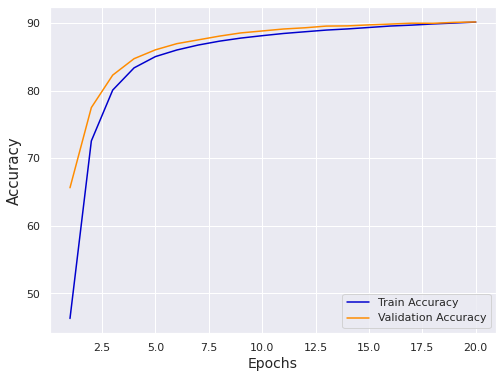

In [82]:
plt.subplots(figsize=(8,6))
e=np.arange(1,21)
plt.plot(e,model1.train_accuracy, color='mediumblue',label='Train Accuracy')
plt.plot(e,model1.val_accuracy, color='darkorange',label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs', size=14)
plt.ylabel('Accuracy', size=15)
plt.show()

#**Q8)c) Best Validation Loss vs Hidden Layer Size**

In [83]:
nn32= NeuralNetwork(hidden_layer_size=32)
nn32.to(cuda0)
model32= Model(nn32, epochs=10, lr=1e-3)
model32.fit()

Epoch-->0 Training Error = 0.016515929749011993 CrossVal Error = 0.0147699942111969
Epoch-->1 Training Error = 0.012718010206222534 CrossVal Error = 0.010995002210140228
Epoch-->2 Training Error = 0.009519435622692108 CrossVal Error = 0.008373509472608566
Epoch-->3 Training Error = 0.007485626538991928 CrossVal Error = 0.006813278871774673
Epoch-->4 Training Error = 0.0062388035106658935 CrossVal Error = 0.005815692394971848
Epoch-->5 Training Error = 0.005433698375225067 CrossVal Error = 0.005146233510971069
Epoch-->6 Training Error = 0.0048782755064964295 CrossVal Error = 0.0046866250991821285
Epoch-->7 Training Error = 0.00447503110229969 CrossVal Error = 0.004357025355100632
Epoch-->8 Training Error = 0.004170076760053635 CrossVal Error = 0.0040619530141353605
Epoch-->9 Training Error = 0.003931422109603882 CrossVal Error = 0.0038557096898555756


In [84]:
nn64= NeuralNetwork(hidden_layer_size=64)
nn64.to(cuda0)
model64= Model(nn64, epochs=10, lr=1e-3)
model64.fit()

Epoch-->0 Training Error = 0.01538373618364334 CrossVal Error = 0.013142715764045715
Epoch-->1 Training Error = 0.010972351675033569 CrossVal Error = 0.009270321953296662
Epoch-->2 Training Error = 0.007966270024776458 CrossVal Error = 0.006995988091826439
Epoch-->3 Training Error = 0.006304950264692306 CrossVal Error = 0.0057837342381477355
Epoch-->4 Training Error = 0.005342518625855446 CrossVal Error = 0.005033346921205521
Epoch-->5 Training Error = 0.004729214171767235 CrossVal Error = 0.004548766234517098
Epoch-->6 Training Error = 0.004308062797188759 CrossVal Error = 0.004152661296725273
Epoch-->7 Training Error = 0.004001598399877548 CrossVal Error = 0.0039006734549999235
Epoch-->8 Training Error = 0.003767948573231697 CrossVal Error = 0.0037401750177145005
Epoch-->9 Training Error = 0.0035850237369537356 CrossVal Error = 0.00354994341135025


In [85]:
nn128= NeuralNetwork(hidden_layer_size=128)
nn128.to(cuda0)
model128= Model(nn128, epochs=10, lr=1e-3)
model128.fit()

Epoch-->0 Training Error = 0.015389625196456909 CrossVal Error = 0.013020533347129822
Epoch-->1 Training Error = 0.010800476109981538 CrossVal Error = 0.009095426988601685
Epoch-->2 Training Error = 0.007819639712572098 CrossVal Error = 0.006888541430234909
Epoch-->3 Training Error = 0.00618835452914238 CrossVal Error = 0.005678252011537552
Epoch-->4 Training Error = 0.005248547937870026 CrossVal Error = 0.0049489435464143755
Epoch-->5 Training Error = 0.00465303244292736 CrossVal Error = 0.004457595971226692
Epoch-->6 Training Error = 0.004246447193026543 CrossVal Error = 0.004093893474340439
Epoch-->7 Training Error = 0.003948515655994416 CrossVal Error = 0.0038873601883649828
Epoch-->8 Training Error = 0.0037230246448516848 CrossVal Error = 0.0036594004362821577
Epoch-->9 Training Error = 0.003547214044332504 CrossVal Error = 0.00348463000357151


In [86]:
nn256= NeuralNetwork(hidden_layer_size=256)
nn256.to(cuda0)
model256= Model(nn256, epochs=10, lr=1e-3)
model256.fit()

Epoch-->0 Training Error = 0.015477645308971406 CrossVal Error = 0.013055810642242432
Epoch-->1 Training Error = 0.010808281247615814 CrossVal Error = 0.009057814967632293
Epoch-->2 Training Error = 0.007758126119375229 CrossVal Error = 0.006822803908586502
Epoch-->3 Training Error = 0.006108169476985932 CrossVal Error = 0.0056254732608795165
Epoch-->4 Training Error = 0.00517269465148449 CrossVal Error = 0.004890201020240783
Epoch-->5 Training Error = 0.004582928416132927 CrossVal Error = 0.004416810700297356
Epoch-->6 Training Error = 0.0041814101266860965 CrossVal Error = 0.004047467425465584
Epoch-->7 Training Error = 0.0038887987798452376 CrossVal Error = 0.0037929928839206695
Epoch-->8 Training Error = 0.003667641746401787 CrossVal Error = 0.003614154705405235
Epoch-->9 Training Error = 0.003494036458134651 CrossVal Error = 0.003444932582974434


In [87]:
nn512= NeuralNetwork(hidden_layer_size=512)
nn512.to(cuda0)
model512= Model(nn512, epochs=10, lr=1e-3)
model512.fit()

Epoch-->0 Training Error = 0.014999128189086913 CrossVal Error = 0.012237430191040038
Epoch-->1 Training Error = 0.010007127608060837 CrossVal Error = 0.008384581238031387
Epoch-->2 Training Error = 0.007221887307167053 CrossVal Error = 0.006427788782119751
Epoch-->3 Training Error = 0.005778179979324341 CrossVal Error = 0.0053661864519119265
Epoch-->4 Training Error = 0.0049530354708433155 CrossVal Error = 0.004690326666831971
Epoch-->5 Training Error = 0.00442491999566555 CrossVal Error = 0.004248817870020866
Epoch-->6 Training Error = 0.004057954996228218 CrossVal Error = 0.003943554696440697
Epoch-->7 Training Error = 0.0037871999186277388 CrossVal Error = 0.0036943616330623627
Epoch-->8 Training Error = 0.003580699076652527 CrossVal Error = 0.0035176076531410216
Epoch-->9 Training Error = 0.003416257442831993 CrossVal Error = 0.0034013614535331727


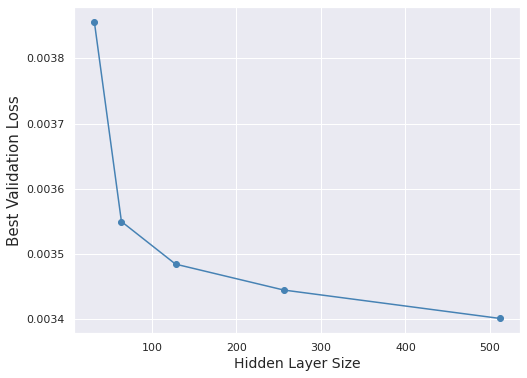

In [88]:
#Loop to get best validation scores
l=[model32,model64,model128,model256,model512]
best_val_loss=[]
for network in l:
    best_val_loss.append(network.val_loss_arr[::-1][0])

plt.subplots(figsize=(8,6))
plt.plot([2**i for i in range(5,10)], best_val_loss, '-o', color='steelblue')
plt.xlabel('Hidden Layer Size', size=14)
plt.ylabel('Best Validation Loss', size=15)
plt.show()

In [89]:
nn1= NeuralNetwork(hidden_layer_size=128)
nn1.to(cuda0)
model_a= Model(nn1, epochs=10, lr=1e-5)
model_a.fit()

Epoch-->0 Training Error = 0.01805491903781891 CrossVal Error = 0.018198409080505372
Epoch-->1 Training Error = 0.017990308175086976 CrossVal Error = 0.018145684194564818
Epoch-->2 Training Error = 0.017926037034988403 CrossVal Error = 0.01807644989490509
Epoch-->3 Training Error = 0.017863479104042054 CrossVal Error = 0.018015181159973144
Epoch-->4 Training Error = 0.01780123471736908 CrossVal Error = 0.017959597086906434
Epoch-->5 Training Error = 0.017739406661987304 CrossVal Error = 0.01789208207130432
Epoch-->6 Training Error = 0.017678343896865845 CrossVal Error = 0.01783259747028351
Epoch-->7 Training Error = 0.01761774280548096 CrossVal Error = 0.017764402055740355
Epoch-->8 Training Error = 0.01755816628932953 CrossVal Error = 0.017708951592445375
Epoch-->9 Training Error = 0.017498854055404665 CrossVal Error = 0.01764478189945221


In [90]:
nn1= NeuralNetwork(hidden_layer_size=128)
nn1.to(cuda0)
model_b= Model(nn1, epochs=10, lr=1e-4)
model_b.fit()

Epoch-->0 Training Error = 0.01777375428199768 CrossVal Error = 0.01764175035953522
Epoch-->1 Training Error = 0.01718406286239624 CrossVal Error = 0.017079302048683166
Epoch-->2 Training Error = 0.016634639263153075 CrossVal Error = 0.016534929156303405
Epoch-->3 Training Error = 0.016109703147411347 CrossVal Error = 0.016014690685272216
Epoch-->4 Training Error = 0.015597287380695343 CrossVal Error = 0.01550918869972229
Epoch-->5 Training Error = 0.015091668787002563 CrossVal Error = 0.01499766536951065
Epoch-->6 Training Error = 0.01459090613603592 CrossVal Error = 0.01449112207889557
Epoch-->7 Training Error = 0.014093797302246094 CrossVal Error = 0.013992940807342528
Epoch-->8 Training Error = 0.013602910482883453 CrossVal Error = 0.013498223614692688
Epoch-->9 Training Error = 0.013120460684299468 CrossVal Error = 0.013016434288024903


In [91]:
nn1= NeuralNetwork(hidden_layer_size=128)
nn1.to(cuda0)
model_c= Model(nn1, epochs=10, lr=1e-3)
model_c.fit()

Epoch-->0 Training Error = 0.015389625196456909 CrossVal Error = 0.013020533347129822
Epoch-->1 Training Error = 0.010800476109981538 CrossVal Error = 0.009095426988601685
Epoch-->2 Training Error = 0.007819639712572098 CrossVal Error = 0.006888541430234909
Epoch-->3 Training Error = 0.00618835452914238 CrossVal Error = 0.005678252011537552
Epoch-->4 Training Error = 0.005248547937870026 CrossVal Error = 0.0049489435464143755
Epoch-->5 Training Error = 0.00465303244292736 CrossVal Error = 0.004457595971226692
Epoch-->6 Training Error = 0.004246447193026543 CrossVal Error = 0.004093893474340439
Epoch-->7 Training Error = 0.003948515655994416 CrossVal Error = 0.0038873601883649828
Epoch-->8 Training Error = 0.0037230246448516848 CrossVal Error = 0.0036594004362821577
Epoch-->9 Training Error = 0.003547214044332504 CrossVal Error = 0.00348463000357151


In [92]:
nn1= NeuralNetwork(hidden_layer_size=128)
nn1.to(cuda0)
model_d= Model(nn1, epochs=10, lr=1e-2)
model_d.fit()

Epoch-->0 Training Error = 0.006594263524413109 CrossVal Error = 0.0035184580087661743
Epoch-->1 Training Error = 0.0030435168033838274 CrossVal Error = 0.002748158337175846
Epoch-->2 Training Error = 0.002580598555803299 CrossVal Error = 0.002459004205465317
Epoch-->3 Training Error = 0.002337153560221195 CrossVal Error = 0.002267097802460194
Epoch-->4 Training Error = 0.0021627303314208984 CrossVal Error = 0.0021293777450919153
Epoch-->5 Training Error = 0.0020234334790706636 CrossVal Error = 0.00201340554356575
Epoch-->6 Training Error = 0.001905135560631752 CrossVal Error = 0.0019030238538980484
Epoch-->7 Training Error = 0.0018007193376123906 CrossVal Error = 0.0018632885232567787
Epoch-->8 Training Error = 0.0017079021787643432 CrossVal Error = 0.0017492194652557374
Epoch-->9 Training Error = 0.0016264044001698494 CrossVal Error = 0.0016738755747675897


In [93]:
nn1= NeuralNetwork(hidden_layer_size=128)
nn1.to(cuda0)
model_e= Model(nn1, epochs=10, lr=1e-1)
model_e.fit()

Epoch-->0 Training Error = 0.0027742166578769685 CrossVal Error = 0.0017057769581675529
Epoch-->1 Training Error = 0.0013538866086304187 CrossVal Error = 0.0011667400367558003
Epoch-->2 Training Error = 0.0009733642680943012 CrossVal Error = 0.0009835086856037378
Epoch-->3 Training Error = 0.0007676270586624742 CrossVal Error = 0.0008266576517373324
Epoch-->4 Training Error = 0.0006310895593464375 CrossVal Error = 0.0008075882382690907
Epoch-->5 Training Error = 0.0005265920263156295 CrossVal Error = 0.0006997676093131303
Epoch-->6 Training Error = 0.0004537344432622194 CrossVal Error = 0.0007506296219304204
Epoch-->7 Training Error = 0.00038912868659943343 CrossVal Error = 0.0006431736689060927
Epoch-->8 Training Error = 0.00033943709621205926 CrossVal Error = 0.0006130579711869359
Epoch-->9 Training Error = 0.0003009061568230391 CrossVal Error = 0.0006198567302897573


#**Q8)d) Best Validation Loss vs Learning Rate**

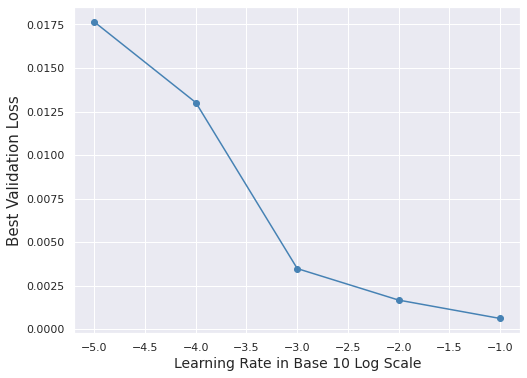

In [94]:
l=[model_a, model_b,model_c, model_d,model_e]
l2= [1e-5,1e-4,1e-3,1e-2,1e-1]
best_val_loss=[]

for model in l:
    best_val_loss.append(model.val_loss_arr[::-1][0])
    
plt.subplots(figsize=(8,6))
plt.plot(np.log(l2)/2.303, best_val_loss, '-o', color='steelblue')
plt.xlabel('Learning Rate in Base 10 Log Scale', size=14)
plt.ylabel('Best Validation Loss', size=15)
plt.show()

#**Q8)e)Test Set Predicted Labels and Test Accuracy + Loss**

In [102]:
nn_best= NeuralNetwork(hidden_layer_size=512)
nn_best.to(cuda0)
model_best= Model(nn_best, epochs=20, lr=1e-1)
model_best.fit()

Epoch-->0 Training Error = 0.0026398418210446836 CrossVal Error = 0.0015960940048098564
Epoch-->1 Training Error = 0.001243443438410759 CrossVal Error = 0.001134772615879774
Epoch-->2 Training Error = 0.0008778068977221846 CrossVal Error = 0.0009030606105923653
Epoch-->3 Training Error = 0.0006779022198915482 CrossVal Error = 0.0008400593206286431
Epoch-->4 Training Error = 0.0005447806676104665 CrossVal Error = 0.0006993467062711715
Epoch-->5 Training Error = 0.00044846961721777917 CrossVal Error = 0.0006793286848813296
Epoch-->6 Training Error = 0.0003696231449022889 CrossVal Error = 0.0006133168686181307
Epoch-->7 Training Error = 0.0003146592605765909 CrossVal Error = 0.000604918614262715
Epoch-->8 Training Error = 0.0002645672898832709 CrossVal Error = 0.0005886036741547286
Epoch-->9 Training Error = 0.0002262507754471153 CrossVal Error = 0.0005525328672491014
Epoch-->10 Training Error = 0.0001951642755791545 CrossVal Error = 0.000555985900387168
Epoch-->11 Training Error = 0.0001

In [117]:
model_best.test()
print('Test set loss is %f'%model_best.test_loss)

Test Set Accuracy is : 98.220
Test set loss is 0.000468


#**Extra Credit**

In [ ]:
class NNConv(nn.Module):
    def __init__(self):
        super(NNConv,self).__init__()
        self.conv1= 
        self.conv1_drop=
        self.linear1= nn.Linear
        self.linear2= nn.Linear

    def forward(self, X):
        X1= torch.flatten(X, start_dim=1, end_dim=-1)
        